# Final Project 
# Constrained Path Auxiliary Field Quantum Monte Carlo

In the final project, I try to apply the Constrained Path-AFQMC to solving the ground state energy of 2D Hubbard Model.

Hamiltonian of 2D Hubbard Model:

$H = -t\sum_{\{i,j\},\sigma}(c^\dagger_{i,\sigma}c_{j,\sigma}+c^\dagger_{j,\sigma}c_{i,\sigma})+U\sum_i n_{i\uparrow}n_{i\downarrow}$

As we know, for a fermion system, unless the system is half-filled, we will encounter the sign problem when applying Monte Carlo due to the exchange antisymmetry of wave functions. However, by a simple trick of "Constrained Path", the sign problem can be avoided to some degree.

Summary of the algorithm:

- Virtual Time Propagator\
(notation: $M$:the number of sites in the lattice $i$: a particular site)\
Write the Hamiltonian formally as $ \hat{H} = \hat{K} + \hat{V}$\
Using second-order Trotter approximation, $ e^{-\Delta \tau \hat{H}} = e^{-\Delta \tau (\hat{K} + \hat{V})} \approx e^{-\Delta \tau \hat{K}/2} e^{-\Delta \tau \hat{V}} e^{-\Delta \tau \hat{K}/2}$\
For a single electron, we can do the virtual time propagation $e^{-\Delta \tau \hat{K}/2}$, however, the $\hat{V}$ term contains interaction of particles, therefore cannot be propagated directly.\
Applying Hubbard-Stratonovich (HS) transformation, we can get $ e^{-\Delta \tau Un_{i\uparrow}n_{i\downarrow}} = e^{-\Delta \tau U(n_{i\uparrow} + n_{i\downarrow})/2} \sum_{x_i = \pm 1}p(x_i) e^{\gamma x_i (n_{i\uparrow} - n_{i\downarrow})}$ where $\gamma$ is given by $\cosh(\gamma) = e^{-\Delta \tau U/2}$, $p(x_i) = \frac{1}{2}$ with $x_i = \pm 1$. By doing this, we transform the particle-particle interaction into particle-field interaction, and $\vec{x} = (x_1, x_2, ..., x_M)$ is considered as an "Auxiliary Field".\
The virtual time propagator therefore can be written as $ P \approx e^{\Delta \tau E_T}\sum_{\vec{x}}P(\vec{x})\prod_{\sigma = \uparrow, \downarrow}\hat{B}_{K/2}^\sigma \hat{B}_{V}^\sigma(\vec{x}) \hat{B}_{K/2}^\sigma$, where $P(\vec{x}) = (\frac{1}{2})^M$, $\hat{B}_{K/2}^\sigma \equiv e^{-\Delta \tau \hat{K}/2}$, $\hat{B}_{V}^\sigma(\vec{x}) = \prod_i \hat{b}_{V}^\sigma(x_i)$, $\hat{b}_{V}^\sigma(x_i) = e^{-(\Delta \tau U/2 -s(\sigma)\gamma x_i) c^\dagger_{i,\sigma} c_{i,\sigma}}$, $s(\uparrow) = +1, s(\downarrow) = -1$,$E_T$ is the energy of a trial state.

- Importance Sampling\
For a walker k, we can take a random walk: $|\phi_k^{(n+1)}\rangle = e^{\Delta \tau E_T}\sum_{\vec{x}}P(\vec{x})\prod_{\sigma = \uparrow, \downarrow}\hat{B}_{K/2}^\sigma \hat{B}_{V}^\sigma(\vec{x}) \hat{B}_{K/2}^\sigma |\phi_k^{(n)}\rangle$, where the "Auxiliary Field"$\vec{x}$ is sampled via Monte Carlo.\
In Auxiliary Field Quantum Monte Carlo, an important sampling is applied. Define the importance function as $ O_T(\phi_k) \equiv \langle \phi_T | \phi_k \rangle$, which is the overlap between the trial state and the walker. Weight $w = O_T(\phi_k)$. By updating the importance function, we can update the weights of the walkers, and thus driving the ensemble to ground state.

- Constrained Path\
To avoid the sign problem caused by antisymmetry of fermion wave function, we have to redefine a constrained-path importance function as $ O_T(\phi_k) \equiv \max \{ \langle \phi_T | \phi_k \rangle, 0\}$, so that the minus weight will not appear.

It is worth mentioning that the result of CP-AFQMC rely on the trial state, because the path is constrained by the trial state. That is, if the trial state is not chosen properly, the system may never reach the ground state, thus causing systematical error to the result. In practice, we usually choose eigenstates of single-electron hamiltonian to construct a trial state, and it works for small systems.

In below, I implement the CP-AFQMC algorithm and use it to calculate a $ 4 \times 4$ Hubbard Model with OBC, $ N_\uparrow = N_\downarrow = 7$, and plot the convergence of energy.

In [222]:
import numpy as np 
from scipy.linalg import expm
import math
import matplotlib.pyplot as plt
from tqdm import *

In [217]:
# Constants
l_x = 4 # number of sites on x-direction
l_y = 4 # number of sites on y-direction
N_up = 7 # number of spin-up electrons
N_dn = 7 # number of spin-down electrons
N_wlk = 200 # number of random walkers
t = 1.0
U = 4.0
dtau = 0.05 # slice of virtual time

In [220]:
# Constructing single particle hamiltonian with only the hopping terms

def mod(n, k):
    if n >= 0:
        return n % k
    else:
        while n < 0:
            n += k
        return n
    
# get a list for hopping position
# note that by this method we calculated each [i,j] pair twice
def Hop_list(L_x, L_y):
    n = L_x * L_y
    hop_list = []
    for i in range(n):
        for j in range(n):
            if j == i + L_x:
                hop_list.append([i, j])
            elif j == i - L_x:
                hop_list.append([i, j])
            elif j == i - 1 and mod(i-1, L_x) != L_x - 1:
                hop_list.append([i, j])
            elif j == i + 1 and mod(i+1, L_x) != 0:
                hop_list.append([i, j])
    return hop_list

# Bit operation
def ReadBit(n, pos):
    res = (n & (1 << pos)) >> pos
    return res

def FlipBit(n, pos):
    res = n ^ (1 << pos)
    return res

def PickBit(n, pos, num):
    return (n & ((2 ** num - 1) << pos)) >> pos

def countParticle(n): # n represents a state
    n_par = 0
    for i in range(32):
        if n & (1 << i):
            n_par += 1
    return n_par

# creation and annihilation operator
def C(n, pos):
    return FlipBit(n, pos), ReadBit(n, pos) * (-1) ** countParticle(PickBit(n, 0, pos))

def C_dagger(n, pos):
    return FlipBit(n, pos), (1 - ReadBit(n, pos)) * (-1) ** countParticle(PickBit(n, 0, pos))

def hopping(state1, state2, i, j):
    if(state2 == FlipBit(FlipBit(state1, i), j)):
        return 1
    else:
        return 0

def H_k(L_x, L_y):

    N = L_x * L_y
    
    # Get states
    states = []
    for i in range((1 << N)):
        if countParticle(i) == 1:
            states.append(i)
            
    # Get hopping list
    hop_list = Hop_list(L_x, L_y)
    
    # calculate H_k
    H_t = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            value = 0
            for [i_hop, j_hop] in hop_list:
                value += hopping(states[i], states[j], i_hop, j_hop) * \
                         C_dagger(C(states[j], j_hop)[0], i_hop)[1] * C(states[j], j_hop)[1]
            H_t[i, j] = value
            
    H_k = -t * H_t
    return H_k

H_k = H_k(l_x, l_y)

In [221]:
# Initialization

N_site = L_x * L_y
N_par = N_up + N_dn

# B_{K/2}
Proj_k_half = expm(-0.5 * dtau * H_k)

# Find a trial wave function using Exact Diagonalization
eigenvalues, eigenstates = np.linalg.eig(H_k)

Phi_T = np.concatenate((eigenstates[:, :N_up],eigenstates[:, :N_dn]), axis = 1)
E_K = np.sum(eigenvalues[:N_up]) + np.sum(eigenvalues[:N_dn])
n_i_up = np.diag(np.dot(Phi_T[:, :N_up], Phi_T[:, :N_up].T.conjugate())).reshape(-1, 1)
n_i_dn = np.diag(np.dot(Phi_T[:, N_up:N_par], Phi_T[:, N_up:N_par].T.conjugate())).reshape(-1, 1)
E_V = U * np.dot(n_i_up.T.conjugate(), n_i_dn)
E_T = E_K + E_V

In [208]:
 def HalfK_propagator(Phi_k, Phi_T, w, O, N_up, N_par, i_wlk):
    
    Phi_k = np.dot(Proj_k_half, Phi_k)
    
    invO_up = np.linalg.inv(np.dot(Phi_T[:,:N_up].T.conjugate(), Phi_k[:,:N_up]))
    invO_dn = np.linalg.inv(np.dot(Phi_T[:,N_up:N_par].T.conjugate(), Phi_k[:,N_up:N_par]))

    O_new = 1 / (np.linalg.det(invO_up) * np.linalg.det(invO_dn))
    O_ratio = O_new / O[i_wlk]

    # Constrained Path
    if O_ratio > 0:
        O[i_wlk] = O_new
        w[i_wlk] = w[i_wlk] * np.real(O_ratio)
    else:
        w[i_wlk] = 0
        
    return invO_up, invO_dn

# Constructing auxiliary field
gamma = np.arccosh(np.exp(0.5 * dtau * U))
aux_field = np.zeros((2, 2))
aux_field[0, 0] = np.exp(gamma)
aux_field[0, 1] = np.exp(-gamma)
aux_field[1, 0] = np.exp(-gamma)
aux_field[1, 1] = np.exp(gamma)

def V_propagator(Phi_k, Phi_T, w, O, invO_up, invO_dn, N_up, N_par, i_wlk):

    for j in range(N_site):
        phi = (Phi_k[j, :]).reshape(1, -1)
        phi_T = (Phi_T[j, :]).reshape(1, -1)
        
        temp1_up = np.dot(phi[0, :N_up], invO_up).reshape(1, -1)
        temp1_dn = np.dot(phi[0, N_up:N_par], invO_dn).reshape(1, -1)
        temp2_up = np.dot(invO_up, phi_T[0, :N_up].T.conjugate().reshape(-1, 1))
        temp2_dn = np.dot(invO_dn, phi_T[0, N_up:N_par].T.conjugate().reshape(-1, 1))
        
        Gii = np.zeros((2,1), dtype = 'complex')
        Gii[0] = np.dot(temp1_up, phi_T[0, :N_up].T.conjugate().reshape(-1, 1))
        Gii[1] = np.dot(temp1_dn, phi_T[0, N_up:N_par].T.conjugate().reshape(-1, 1))
        G = np.concatenate((Gii,Gii), axis = 1)
        
        mat_one = np.ones((2,2), dtype = 'complex')
        RR = (aux_field - mat_one)* G + mat_one

        O_ratio_temp = (RR[0,:] * RR[1,:]).reshape(-1, 1)
        O_ratio_temp_real = np.zeros((2, 1))
        O_ratio_temp_real[0] = max(np.real(O_ratio_temp[0]), 0)
        O_ratio_temp_real[1] = max(np.real(O_ratio_temp[1]), 0)
        sum_O_ratio_temp_real = O_ratio_temp_real[0] + O_ratio_temp_real[1]

        if sum_O_ratio_temp_real <= 0:
            w[i_wlk] = 0

        x = 0
        rand = np.random.uniform(low=0, high=1)

        if w[i_wlk] > 0:
            w[i_wlk] = w[i_wlk] * 0.5 * sum_O_ratio_temp_real
            
            # perform importance sampling to obtain a binomial distribution
            if O_ratio_temp_real[0] / sum_O_ratio_temp_real >= rand:
                x = 0
            else:
                x = 1
    
        phi[0, :N_up] = phi[0, :N_up] * aux_field[0,x]
        phi[0, N_up:N_par] = phi[0, N_up:N_par] * aux_field[1,x]

        O[i_wlk] = O[i_wlk] * O_ratio_temp[x]
        invO_up = invO_up + (1 - aux_field[0,x]) / RR[0,x] * np.dot(temp2_up, temp1_up)
        invO_dn = invO_dn + (1 - aux_field[1,x]) / RR[1,x] * np.dot(temp2_dn, temp1_dn)
        
        Phi_k[j, :] = phi
        Phi_T[j, :] = phi_T
        
    return invO_up, invO_dn
        
def Measure_Energy(H_k, Phi_k, Phi_T, invO_up, invO_dn, N_up, N_par):

    temp_up = np.dot(Phi_k[:,:N_up], invO_up)
    temp_dn = np.dot(Phi_k[:,N_up:N_par], invO_dn)
    
    G_up = np.dot(temp_up, Phi_T[:,:N_up].T.conjugate())
    G_dn = np.dot(temp_dn, Phi_T[:,N_up:N_par].T.conjugate())

    n_int = np.inner(np.diag(G_up), np.diag(G_dn))
    E_v = U * n_int

    E_k = np.sum(np.sum((H_k.T) * (G_up + G_dn)))
    e = E_v + E_k

    return e
        
def RandomWalk(Phi, w, O, H_k, Phi_T, N_up, N_par):
    
    E_wlk = np.zeros((N_wlk, 1), dtype = 'complex')
    
    for i_wlk in range(N_wlk):
        Phi_k = Phi[:, :, i_wlk]
        
        if w[i_wlk] > 0:
            w[i_wlk] = w[i_wlk] * np.exp(dtau * np.real(E_T) - 0.5 * dtau * U * N_par)
            invO_up = np.eye(N_up, dtype = 'complex')
            invO_dn = np.ones(N_par - N_up, dtype = 'complex')
            invO_up, invO_dn = HalfK_propagator(Phi_k, Phi_T, w, O, N_up, N_par, i_wlk)
            if w[i_wlk] > 0:
                invO_up, invO_dn = V_propagator(Phi_k, Phi_T, w, O, invO_up, invO_dn, N_up, N_par, i_wlk)
            if w[i_wlk] > 0:
                invO_up, invO_dn = HalfK_propagator(Phi_k, Phi_T, w, O, N_up, N_par, i_wlk)
            if w[i_wlk] > 0:
                E_wlk[i_wlk] = Measure_Energy(H_k, Phi_k, Phi_T, invO_up, invO_dn, N_up, N_par)

        Phi[:,:,i_wlk] = Phi_k
        
    # Calculate energy of the ensemble
    E = np.sum(np.real(E_wlk) * w) / np.sum(w)
    return E

In [209]:
def Re_orth(Phi, N_wlk, O, N_up, N_par):
    for i_wlk in range(N_wlk):
        Phi[:,:N_up,i_wlk],R_up = np.linalg.qr(Phi[:,:N_up,i_wlk], mode='reduced')
        Phi[:,N_up:N_par,i_wlk],R_dn = np.linalg.qr(Phi[:,N_up:N_par,i_wlk], mode='reduced')
        O[i_wlk] = O[i_wlk] / (np.linalg.det(R_up) * np.linalg.det(R_dn))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.13it/s]


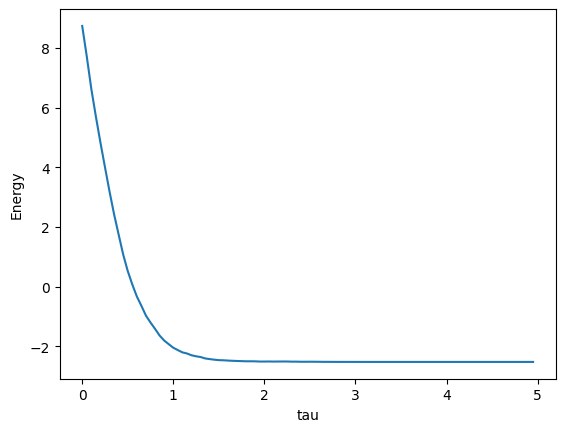

In [211]:
# Initializing random walkers
Phi_tot = np.zeros((N_site,N_par,N_wlk), dtype = 'complex')
for i_wlk in range(N_wlk): # ith random walker
    Phi_tot[:, :, i_wlk] = Phi_T

w = np.ones((N_wlk, 1), dtype = 'float')
O = np.ones((N_wlk, 1), dtype = 'complex')

energy_his = [[], []]

for iter_num in tqdm(range(100)):
    E = RandomWalk(Phi_tot, w, O, H_k, Phi_T, N_up, N_par)
    Re_orth(Phi_tot, N_wlk, O, N_up, N_par)

    new_E = E.copy()
    tau = iter_num * dtau
    energy_his[0].append(tau)
    energy_his[1].append(new_E)

plt.plot(energy_his[0], energy_his[1])
plt.xlabel("tau")
plt.ylabel("Energy")
plt.show()

From the result we can see that the energy converged well and thus avoided the sign problem.